# <!-- TITLE --> Sentiment analysis
<!-- DESC --> This notebook is an example of sentiment analysis using a dataset from Internet Movie Database (IMDB). 
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - The objective is to guess whether film reviews are **positive or negative** based on the analysis of the text. 
 - Understand the management of **textual data** and **sentiment analysis**

It is decomposed in 3 parts:

- **Part 1**: Build a classifier with one-hot encoding
- **Part 2**: Replace one-hot endodings by word embeddings
- **Part 3**: Combine word embedding and a recurrent architecture

Original dataset can be find **[there](http://ai.stanford.edu/~amaas/data/sentiment/)**  
Note that [IMDb.com](https://imdb.com) offers several easy-to-use [datasets](https://www.imdb.com/interfaces/)  
For simplicity's sake, we'll use the dataset directly [embedded in Keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a model
 - Train the model
 - Evaluate the result

Disclaimer: This notebook is based on [fidle-cnrs](https://gricad-gitlab.univ-grenoble-alpes.fr/talks/fidle/-/tree/master)

# Preliminaries: import and init

In [2]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets.imdb as imdb

import matplotlib.pyplot as plt
import matplotlib

import pandas as pd

from sklearn.metrics import confusion_matrix

import os,sys,h5py,json
from importlib import reload

In [3]:
run_dir = os.getcwd()
output_dir='data'

# Part 1: Model based on one-hot encoding

## Step 1 - Parameters

The words in the vocabulary are classified from the most frequent to the rarest.\
`vocab_size` is the number of words we will remember in our vocabulary (the other words will be considered as unknown).\
`hide_most_frequently` is the number of ignored words, among the most common ones\
`fit_verbosity` is the verbosity during training : 0 = silent, 1 = progress bar, 2 = one line per epoch

In [68]:
vocab_size           = 5000
hide_most_frequently = 0

epochs               = 10
batch_size           = 512
fit_verbosity        = 1

## Step 2 - Understanding hot-one encoding
#### We have a **sentence** and a **dictionary** :

In [69]:
sentence = "I've never seen a movie like this before"

dictionary  = {"a":0, "before":1, "fantastic":2, "i've":3, "is":4, "like":5, "movie":6, "never":7, "seen":8, "this":9}

#### We encode our sentence as a **numerical vector** :

In [70]:
sentence_words = sentence.lower().split()

sentence_vect  = [ dictionary[w] for w in sentence_words ]

print('Words sentence are         : ', sentence_words)
print('Our vectorized sentence is : ', sentence_vect)

Words sentence are         :  ["i've", 'never', 'seen', 'a', 'movie', 'like', 'this', 'before']
Our vectorized sentence is :  [3, 7, 8, 0, 6, 5, 9, 1]


#### Next, we **one-hot** encode our vectorized sentence as a tensor :

In [71]:
# ---- We get a (sentence length x vector size) matrix of zeros
#
onehot = np.zeros( (10,8) )

# ---- We set some 1 for each word
#
for i,w in enumerate(sentence_vect):
    onehot[w,i]=1

# --- Show it
#
print('In a basic way :\n\n', onehot, '\n\nWith a pandas wiew :\n')
data={ f'{sentence_words[i]:.^10}':onehot[:,i] for i,w in enumerate(sentence_vect) }
df=pd.DataFrame(data)
df.index=dictionary.keys()
# --- Pandas Warning 
# 
df.style.format('{:1.0f}').highlight_max(axis=0).set_properties(**{'text-align': 'center'})

In a basic way :

 [[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]] 

With a pandas wiew :



,...i've...,..never...,...seen...,....a.....,..movie...,...like...,...this...,..before..
a,0,0,0,1,0,0,0,0
before,0,0,0,0,0,0,0,1
fantastic,0,0,0,0,0,0,0,0
i've,1,0,0,0,0,0,0,0
is,0,0,0,0,0,0,0,0
like,0,0,0,0,0,1,0,0
movie,0,0,0,0,1,0,0,0
never,0,1,0,0,0,0,0,0
seen,0,0,1,0,0,0,0,0
this,0,0,0,0,0,0,1,0


### 3.2 - Load dataset
For simplicity, we will use a pre-formatted dataset - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data)  
However, Keras offers some usefull tools for formatting textual data - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text)  

By default : 
 - Start of a sequence will be marked with : 1
 - Out of vocabulary word will be : 2
 - First index will be : 3

In [72]:
# ----- Retrieve x,y
#
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words=vocab_size, skip_top=hide_most_frequently)

y_train = np.asarray(y_train).astype('float32')
y_test  = np.asarray(y_test ).astype('float32')

# ---- About
#
print("x_train : {}  y_train : {}".format(x_train.shape, y_train.shape))
print("x_test  : {}  y_test  : {}".format(x_test.shape,  y_test.shape))

x_train : (25000,)  y_train : (25000,)
x_test  : (25000,)  y_test  : (25000,)


## Step 4 - About our dataset
When we loaded the dataset, we asked for using \<start\> as 1, \<unknown word\> as 2  
So, we shifted the dataset by 3 with the parameter index_from=3

### 4.1 - Sentences encoding

In [73]:
print('\nReview example (x_train[12]) :\n\n',x_train[12])
print('\nOpinions (y_train) :\n\n',y_train)


Review example (x_train[12]) :

 [1, 13, 119, 954, 189, 1554, 13, 92, 459, 48, 4, 116, 9, 1492, 2291, 42, 726, 4, 1939, 168, 2031, 13, 423, 14, 20, 549, 18, 4, 2, 547, 32, 4, 96, 39, 4, 454, 7, 4, 22, 8, 4, 55, 130, 168, 13, 92, 359, 6, 158, 1511, 2, 42, 6, 1913, 19, 194, 4455, 4121, 6, 114, 8, 72, 21, 465, 2, 304, 4, 51, 9, 14, 20, 44, 155, 8, 6, 226, 162, 616, 651, 51, 9, 14, 20, 44, 10, 10, 14, 218, 4843, 629, 42, 3017, 21, 48, 25, 28, 35, 534, 5, 6, 320, 8, 516, 5, 42, 25, 181, 8, 130, 56, 547, 3571, 5, 1471, 851, 14, 2286]

Opinions (y_train) :

 [1. 0. 0. ... 0. 1. 0.]


### 4.2 - Load dictionary

In [74]:
# ---- Retrieve dictionary {word:index}, and encode it in ascii
#
word_index = imdb.get_word_index()

# ---- Shift the dictionary from +3
#
word_index = {w:(i+3) for w,i in word_index.items()}

# ---- Add <pad>, <start> and <unknown> tags
#
word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2, '<undef>':3,} )

# ---- Create a reverse dictionary : {index:word}
#
index_word = {index:word for word,index in word_index.items()} 

# ---- About dictionary
#
print('\nDictionary size     : ', len(word_index))
print('\nSmall extract :\n')
for k in range(440,455):print(f'    {k:2d} : {index_word[k]}' )

# ---- Add a nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])


Dictionary size     :  88588

Small extract :

    440 : hope
    441 : entertaining
    442 : she's
    443 : mr
    444 : overall
    445 : evil
    446 : called
    447 : loved
    448 : based
    449 : oh
    450 : several
    451 : fans
    452 : mother
    453 : drama
    454 : beginning


### 4.3 - Have a look, for human

In [75]:
print(f'Review example : \n{x_train[12]}')

print(f'After translation : \n{dataset2text(x_train[12])}')

Review example : 
[1, 13, 119, 954, 189, 1554, 13, 92, 459, 48, 4, 116, 9, 1492, 2291, 42, 726, 4, 1939, 168, 2031, 13, 423, 14, 20, 549, 18, 4, 2, 547, 32, 4, 96, 39, 4, 454, 7, 4, 22, 8, 4, 55, 130, 168, 13, 92, 359, 6, 158, 1511, 2, 42, 6, 1913, 19, 194, 4455, 4121, 6, 114, 8, 72, 21, 465, 2, 304, 4, 51, 9, 14, 20, 44, 155, 8, 6, 226, 162, 616, 651, 51, 9, 14, 20, 44, 10, 10, 14, 218, 4843, 629, 42, 3017, 21, 48, 25, 28, 35, 534, 5, 6, 320, 8, 516, 5, 42, 25, 181, 8, 130, 56, 547, 3571, 5, 1471, 851, 14, 2286]
After translation : 
<start> i love cheesy horror flicks i don't care if the acting is sub par or whether the monsters look corny i liked this movie except for the <unknown> feeling all the way from the beginning of the film to the very end look i don't need a 10 page <unknown> or a sign with big letters explaining a plot to me but dark <unknown> takes the what is this movie about thing to a whole new annoying level what is this movie about br br this isn't exceptionally scary

### 4.4 - Few statistics

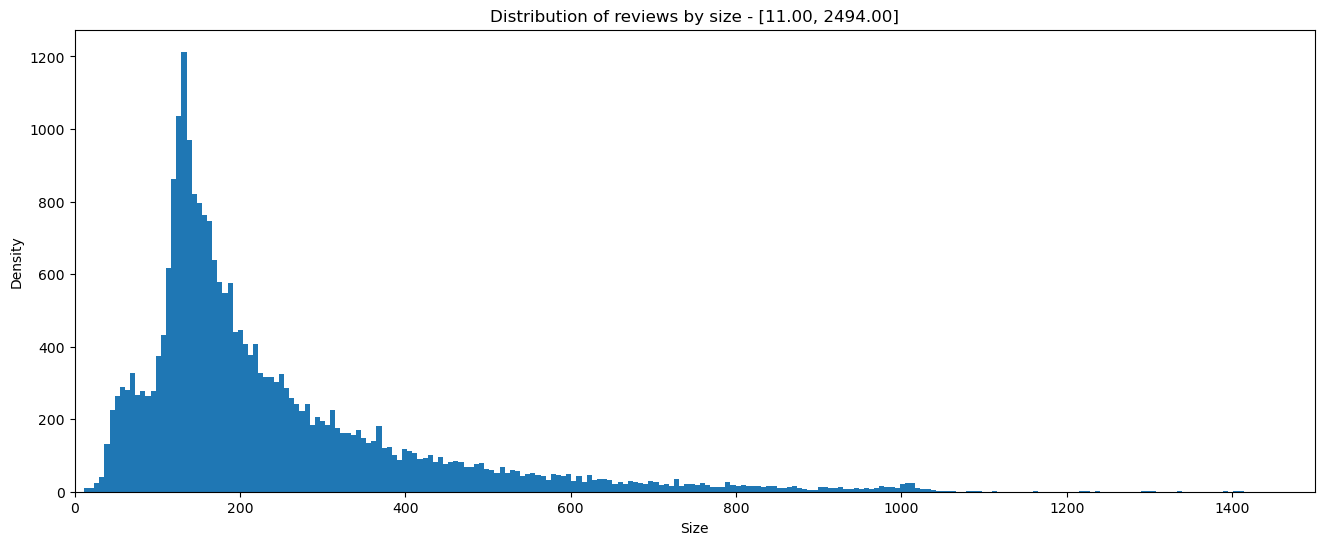

In [76]:
sizes=[len(i) for i in x_train]
plt.figure(figsize=(16,6))
plt.hist(sizes, bins=400)
plt.gca().set(title='Distribution of reviews by size - [{:5.2f}, {:5.2f}]'.format(min(sizes),max(sizes)), 
              xlabel='Size', ylabel='Density', xlim=[0,1500])
plt.show()

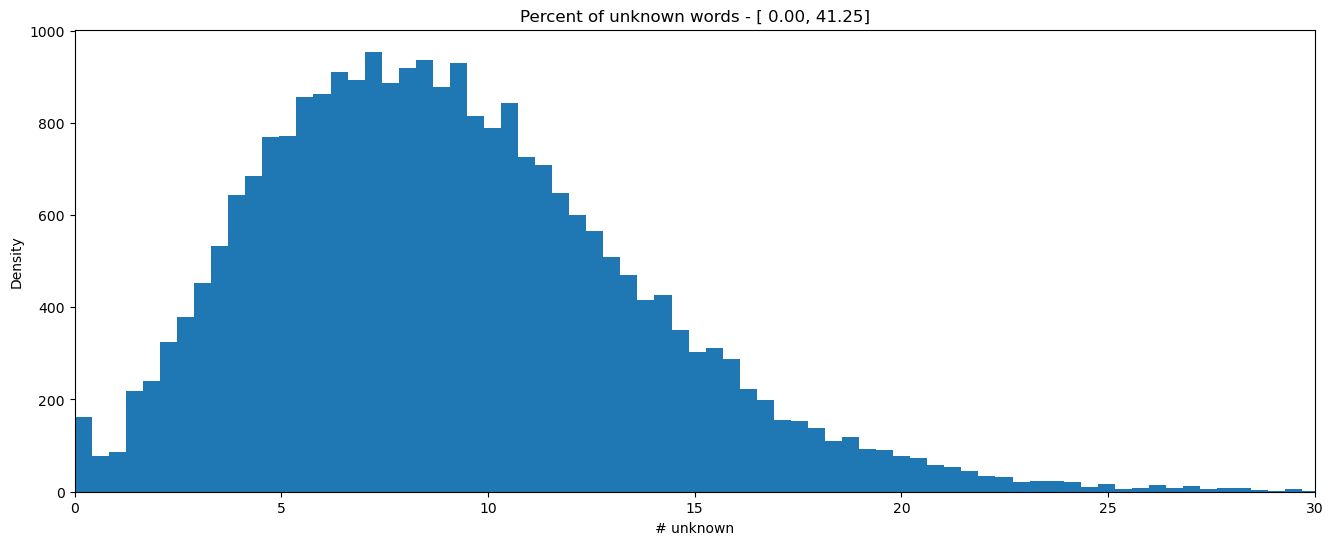

In [77]:
unk=[ 100*(s.count(2)/len(s)) for s in x_train]
plt.figure(figsize=(16,6))
plt.hist(unk, bins=100)
plt.gca().set(title='Percent of unknown words - [{:5.2f}, {:5.2f}]'.format(min(unk),max(unk)), 
              xlabel='# unknown', ylabel='Density', xlim=[0,30])
plt.show()

## Step 5 - Basic approach with "one-hot" vector encoding

Each sentence is encoded with a **vector** of length equal to the **size of the dictionary**.   

Each sentence will therefore be encoded with a simple vector.  
The value of each component is 0 if the word is not present in the sentence or 1 if the word is present.

For a sentence s=[3,4,7] and a dictionary of 10 words...    
We wil have a vector v=[0,0,0,1,1,0,0,1,0,0,0]

### 5.1 - Our one-hot encoder

In [78]:
def one_hot_encoder(x, vector_size=10000):
    
    # ---- Set all to 0
    #
    x_encoded = np.zeros((len(x), vector_size))
    
    # ---- For each sentence
    #
    for i,sentence in enumerate(x):
        for word in sentence:
            x_encoded[i, word] = 1.

    return x_encoded

### 5.2 - Encoding

In [79]:
x_train_one_hot = one_hot_encoder(x_train, vector_size=vocab_size)
x_test_one_hot  = one_hot_encoder(x_test,  vector_size=vocab_size)

print("To have a look, x_train[12] became :", x_train_one_hot[12] )

To have a look, x_train[12] became : [0. 1. 1. ... 0. 0. 0.]


## Step 6 - Build the model

In [80]:
def get_model(vector_size=10000):
    
    model = keras.Sequential()
    model.add(keras.layers.Input( shape=(vector_size,) ))
    model.add(keras.layers.Dense( 32, activation='relu'))
    model.add(keras.layers.Dense( 32, activation='relu'))
    model.add(keras.layers.Dense( 1, activation='sigmoid'))
    
    model.compile(optimizer = 'rmsprop',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

## Step 7 - Train the model
### 7.1 - Get it

In [81]:
model = get_model(vector_size=vocab_size)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                160032    
                                                                 
 dense_13 (Dense)            (None, 32)                1056      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 161,121
Trainable params: 161,121
Non-trainable params: 0
_________________________________________________________________


### 7.2 - Add callback

In [82]:
os.makedirs(f'{run_dir}/models',   mode=0o750, exist_ok=True)
save_dir = f'{run_dir}/models/best_model_one_hot.h5'
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 7.3 - Train it

In [83]:
%%time

history = model.fit(x_train_one_hot,
                    y_train,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test_one_hot, y_test),
                    verbose         = fit_verbosity,
                    callbacks       = [savemodel_callback])


Epoch 1/10
49/49 [==============================] - 2s 17ms/step - loss: 0.4470 - accuracy: 0.8142 - val_loss: 0.3222 - val_accuracy: 0.8792
Epoch 2/10
49/49 [==============================] - 0s 8ms/step - loss: 0.2680 - accuracy: 0.8982 - val_loss: 0.3211 - val_accuracy: 0.8675
Epoch 3/10
49/49 [==============================] - 0s 8ms/step - loss: 0.2266 - accuracy: 0.9135 - val_loss: 0.2989 - val_accuracy: 0.8799
Epoch 4/10
49/49 [==============================] - 0s 7ms/step - loss: 0.2023 - accuracy: 0.9230 - val_loss: 0.3116 - val_accuracy: 0.8755
Epoch 5/10
49/49 [==============================] - 0s 8ms/step - loss: 0.1819 - accuracy: 0.9306 - val_loss: 0.3204 - val_accuracy: 0.8756
Epoch 6/10
49/49 [==============================] - 1s 11ms/step - loss: 0.1660 - accuracy: 0.9376 - val_loss: 0.3269 - val_accuracy: 0.8756
Epoch 7/10
49/49 [==============================] - 0s 8ms/step - loss: 0.1498 - accuracy: 0.9440 - val_loss: 0.3475 - val_accuracy: 0.8724
Epoch 8/10
49/49 [

## Step 8 - Evaluate
### 8.1 - Training history

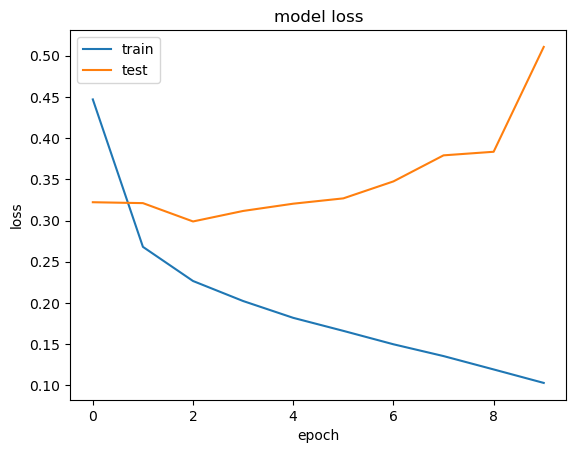

In [84]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

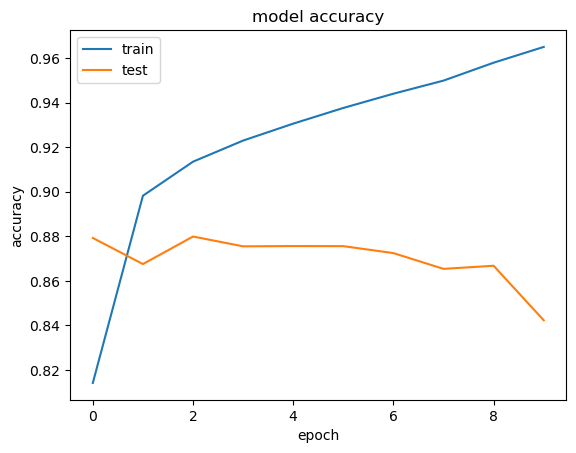

In [85]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 8.2 - Reload and evaluate best model

In [26]:
model = keras.models.load_model(f'{run_dir}/models/best_model_one_hot.h5')

# ---- Evaluate
score  = model.evaluate(x_test_one_hot, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]

# ---- Confusion matrix

y_sigmoid = model.predict(x_test_one_hot)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1    

confusion_matrix(y_test, y_pred, labels=range(2))

x_test / loss      : 0.2857
x_test / accuracy  : 0.8850
782/782 [==============================] - 1s 1ms/step


array([[10883,  1617],
       [ 1258, 11242]], dtype=int64)

## Questions

1. What are the drawbacks of this encoding approach?
2. Does the model seem to overfit/underfit the data? On which hyperparameter(s) can you act to resolve this?

__Answer__ : 
1. The main problem with one-hot encoding is that we lose the order of the words in the sentence. That's why the layers of our network gradually increase the size of the input. One might suspect memory problems for larger datasets. But since the arrays are sparse, this problem is not the main one. For even larger datasets, we could also talk about temporal and spatial costs. There is also a semantic problem: it may not be efficient to capture semantic and contextual relations between words. For example, the words "car" and "automobile" have similar meanings, but they would be represented in a completely different way in One-hot Encoding. Inability to handle unknown words: If a word is not present in the vocabulary, it cannot be represented in One-hot Encoding, which can lead to the loss of important information.
2. After epoch 2, the model seems to overfit (the loss function starts to go up and the accuracy on the test set starts to decrease). Some ideas to resolve this (i tried below) : we could have played on hiding most frequently, to hide most frequent words and complexify our model, we could have added EarlyStopping (classic method to avoid overfitting), change our Dense Layers, our optimizer, our number of epochs and our batch size. We might have thought about dropout to harden our model.

In [105]:
vocab_size           = 5000
hide_most_frequently = 0

epochs               = 20
batch_size           = 800
fit_verbosity        = 1

def get_model(vector_size=10_000):
    
    model = keras.Sequential()
    model.add(keras.layers.Input( shape=(vector_size,) ))
    model.add(keras.layers.Dense( 64, activation='relu'))
    model.add(keras.layers.Dense( 32, activation='relu'))
    model.add(keras.layers.Dense( 1, activation='sigmoid'))
    
    model.compile(optimizer = 'rmsprop',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

model = get_model(vector_size=vocab_size)

model.summary()

os.makedirs(f'{run_dir}/models',   mode=0o750, exist_ok=True)
save_dir = f'{run_dir}/models/best_model_one_hot.h5'


my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4),
    tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True),
]

history = model.fit(x_train_one_hot,
                    y_train,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test_one_hot, y_test),
                    verbose         = fit_verbosity,
                    callbacks       = [my_callbacks])


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 64)                320064    
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 322,177
Trainable params: 322,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
32/32 [==============================] - 2s 47ms/step - loss: 0.4689 - accuracy: 0.7926 - val_loss: 0.3942 - val_accuracy: 0.8282
Epoch 2/20
32/32 [==============================] - 0s 14ms/step - loss: 0.2954 - accuracy: 0.8858 - val_loss: 0.2902 - val_accuracy: 0.8858
Epoch 3/20
32/32 [===========

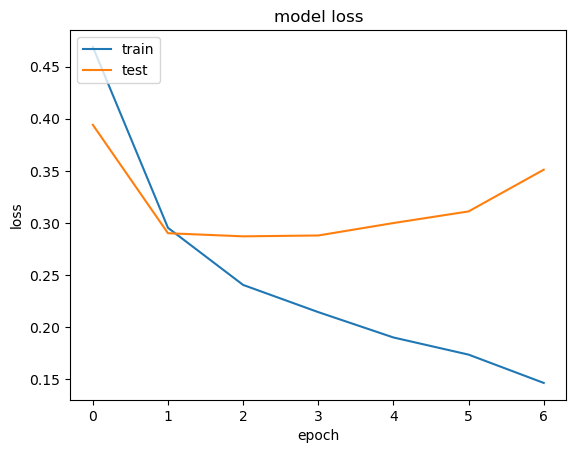

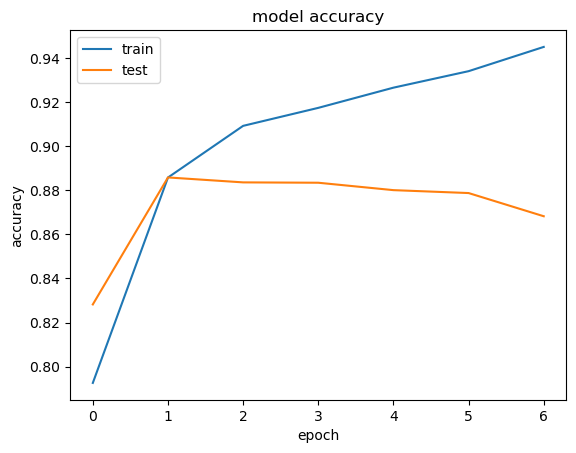

In [106]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [107]:
model = keras.models.load_model(f'{run_dir}/models/best_model_one_hot.h5')

# ---- Evaluate
score  = model.evaluate(x_test_one_hot, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]

# ---- Confusion matrix

y_sigmoid = model.predict(x_test_one_hot)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1    

confusion_matrix(y_test, y_pred, labels=range(2))

x_test / loss      : 0.2872
x_test / accuracy  : 0.8836
782/782 [==============================] - 1s 1ms/step


array([[10624,  1876],
       [ 1035, 11465]], dtype=int64)

Close results, not a lot of progress.

# **Part 2: Word embeddings**

## Step 1 - Preprocess the data

### 1.1 - Parameters
The words in the vocabulary are classified from the most frequent to the rarest.  
`review_len` is the review length  
`dense_vector_size` is the size of the generated dense vectors  
`output_dir` is where we will go to save our dictionaries. (./data is a good choice)\
`fit_verbosity` is the verbosity during training : 0 = silent, 1 = progress bar, 2 = one line per epoch

In [27]:
review_len           = 256
dense_vector_size    = 32

epochs               = 30
batch_size           = 512

output_dir           = './data'
fit_verbosity        = 1

### 1.2 - Padding

In order to be processed by an embedding neural network, all entries must have the **same length.**  
We chose a review length of **review_len**  
We will therefore complete them with a padding (of \<pad\>\)  

In [28]:
x_train_pad = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     value   = 0,
                                                     padding = 'post',
                                                     maxlen  = review_len)

x_test_pad  = keras.preprocessing.sequence.pad_sequences(x_test,
                                                     value   = 0 ,
                                                     padding = 'post',
                                                     maxlen  = review_len)

# fidle.utils.subtitle('After padding :')
print(f'After padding: {x_train_pad[12]}')

After padding: [   1   13  119  954  189 1554   13   92  459   48    4  116    9 1492
 2291   42  726    4 1939  168 2031   13  423   14   20  549   18    4
    2  547   32    4   96   39    4  454    7    4   22    8    4   55
  130  168   13   92  359    6  158 1511    2   42    6 1913   19  194
 4455 4121    6  114    8   72   21  465    2  304    4   51    9   14
   20   44  155    8    6  226  162  616  651   51    9   14   20   44
   10   10   14  218 4843  629   42 3017   21   48   25   28   35  534
    5    6  320    8  516    5   42   25  181    8  130   56  547 3571
    5 1471  851   14 2286    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0  

## Step 2 - Build the model

More documentation about this model functions :
 - [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
 - [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D)

In [29]:
def get_model(vocab_size=10000, dense_vector_size=32, review_len=256):
    
    model = keras.Sequential()
    model.add(keras.layers.Input( shape=(review_len,) ))
    model.add(keras.layers.Embedding(input_dim    = vocab_size, 
                                     output_dim   = dense_vector_size, 
                                     input_length = review_len))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dense(dense_vector_size, activation='relu'))
    model.add(keras.layers.Dense(1,                 activation='sigmoid'))

    model.compile(optimizer = 'adam',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

## Step 3 - Train the model
### 3.1 - Get it

In [30]:
model = get_model(vocab_size, dense_vector_size, review_len)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 32)           160000    
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 161,089
Trainable params: 161,089
Non-trainable params: 0
_________________________________________________________________


### 3.2 - Add callback

In [31]:
os.makedirs(f'{run_dir}/models',   mode=0o750, exist_ok=True)
save_dir = f'{run_dir}/models/best_model_embeddings.h5'
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 3.3 - Train it

In [32]:
%%time

history = model.fit(x_train_pad,
                    y_train,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test_pad, y_test),
                    verbose         = fit_verbosity,
                    callbacks       = [savemodel_callback])


Epoch 1/30
49/49 [==============================] - 2s 22ms/step - loss: 0.6877 - accuracy: 0.6450 - val_loss: 0.6768 - val_accuracy: 0.7252
Epoch 2/30
49/49 [==============================] - 1s 18ms/step - loss: 0.6470 - accuracy: 0.7450 - val_loss: 0.6090 - val_accuracy: 0.7720
Epoch 3/30
49/49 [==============================] - 1s 17ms/step - loss: 0.5485 - accuracy: 0.8010 - val_loss: 0.4995 - val_accuracy: 0.8151
Epoch 4/30
49/49 [==============================] - 1s 17ms/step - loss: 0.4376 - accuracy: 0.8458 - val_loss: 0.4082 - val_accuracy: 0.8463
Epoch 5/30
49/49 [==============================] - 1s 17ms/step - loss: 0.3616 - accuracy: 0.8678 - val_loss: 0.3579 - val_accuracy: 0.8599
Epoch 6/30
49/49 [==============================] - 1s 18ms/step - loss: 0.3162 - accuracy: 0.8825 - val_loss: 0.3304 - val_accuracy: 0.8681
Epoch 7/30
49/49 [==============================] - 1s 17ms/step - loss: 0.2870 - accuracy: 0.8905 - val_loss: 0.3135 - val_accuracy: 0.8733
Epoch 8/30
49

## Step 4 - Evaluate
### 4.1 - Training history

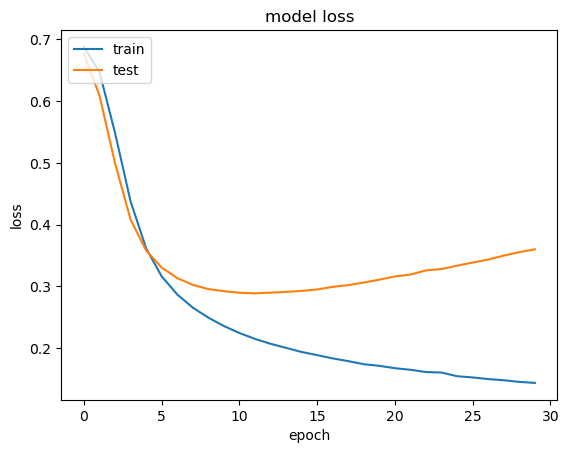

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

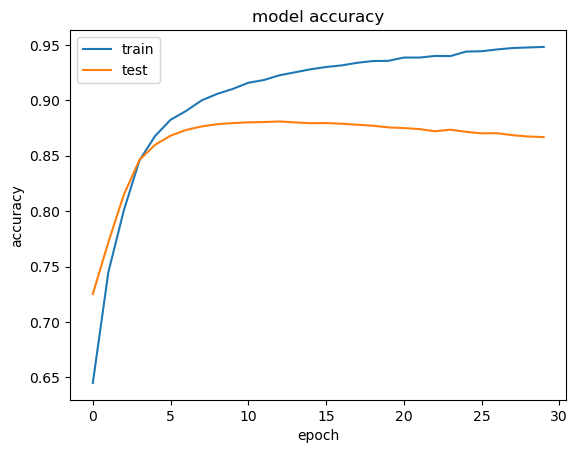

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 4.2 - Reload and evaluate best model

In [35]:
model = keras.models.load_model(f'{run_dir}/models/best_model_embeddings.h5')

# ---- Evaluate
score  = model.evaluate(x_test_pad, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]

# ---- Confusion matrix

y_sigmoid = model.predict(x_test_pad)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1    

confusion_matrix(y_test, y_pred, labels=range(2))

x_test / loss      : 0.2888
x_test / accuracy  : 0.8804
782/782 [==============================] - 1s 2ms/step


array([[10995,  1505],
       [ 1484, 11016]], dtype=int64)

## Questions

1. Compare empirically this model to the one of the previous part (with one-hot encoded features): which one is best in terms of performance, memory and runtime? Which one would you choose and why?
2. What are the theoretical advantages and disadvantages of each approach (in terms of performance, computation, interpretability...)?
3. Change the dimension of the embedding space. How does it influence performance? How would you choose this dimension?

1. We have achieved a slightly higher accuracy and final loss score than before. Nevertheless, the fact of having densified the input vectors makes the model less expensive in memory. Nevertheless, it is more time consuming because the convergence is longer. The loss and score curves are also more continuous than the previous model. After 2 epochs, the first model had already reached its minimum loss and started to overfitter. This second model is certainly more expensive in time, but the convergence seems more reliable and the overfitting comes after more epochs, moreover, it is less expensive in memory. So I will choose this model.

2. 

*First model*: 

- Negative side: expensive in memory (even if the matrices are sparse), lost word order, less efficient to understand semantic and contextual relations of the word than embeddings, unable to handle unknown words. 

- Positive side: fast convergence, easy to set up



*Second model*: 

- Negative side: word order still lost, still not very efficient at understanding semantic and contextual relationships of the word, inability to handle unknown words, even less interpretability.

- Positive side: less space consuming, better performance



3. Let's test this:

Nous n'arrivons pas à converger à des valeurs aussi basses qu'avant en augmentant ou en descendant la taille de l'embedding, la convergence proche de la limite semble très lente.

In [128]:
def get_model(vocab_size=10000, dense_vector_size=64 , review_len=256):
    
    model = keras.Sequential()
    model.add(keras.layers.Input( shape=(review_len,) ))
    model.add(keras.layers.Embedding(input_dim    = vocab_size, 
                                     output_dim   = dense_vector_size, 
                                     input_length = review_len))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dense(dense_vector_size, activation='relu'))
    model.add(keras.layers.Dense(1,                 activation='sigmoid'))

    model.compile(optimizer = 'adam',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

model = get_model(vocab_size, dense_vector_size, review_len)

model.summary()

os.makedirs(f'{run_dir}/models',   mode=0o750, exist_ok=True)
save_dir = f'{run_dir}/models/best_model_embeddings.h5'
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 256, 32)           160000    
                                                                 
 global_average_pooling1d_4   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_42 (Dense)            (None, 32)                1056      
                                                                 
 dense_43 (Dense)            (None, 1)                 33        
                                                                 
Total params: 161,089
Trainable params: 161,089
Non-trainable params: 0
_________________________________________________________________


In [129]:
%%time

history = model.fit(x_train_pad,
                    y_train,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test_pad, y_test),
                    verbose         = fit_verbosity,
                    callbacks       = [savemodel_callback])

Epoch 1/20
32/32 [==============================] - 1s 29ms/step - loss: 0.6919 - accuracy: 0.6079 - val_loss: 0.6893 - val_accuracy: 0.6146
Epoch 2/20
32/32 [==============================] - 1s 23ms/step - loss: 0.6829 - accuracy: 0.6985 - val_loss: 0.6735 - val_accuracy: 0.7311
Epoch 3/20
32/32 [==============================] - 1s 22ms/step - loss: 0.6554 - accuracy: 0.7480 - val_loss: 0.6343 - val_accuracy: 0.7526
Epoch 4/20
32/32 [==============================] - 1s 22ms/step - loss: 0.6020 - accuracy: 0.7760 - val_loss: 0.5726 - val_accuracy: 0.7922
Epoch 5/20
32/32 [==============================] - 1s 22ms/step - loss: 0.5298 - accuracy: 0.8133 - val_loss: 0.5009 - val_accuracy: 0.8171
Epoch 6/20
32/32 [==============================] - 1s 23ms/step - loss: 0.4569 - accuracy: 0.8418 - val_loss: 0.4392 - val_accuracy: 0.8376
Epoch 7/20
32/32 [==============================] - 1s 30ms/step - loss: 0.3979 - accuracy: 0.8589 - val_loss: 0.3941 - val_accuracy: 0.8502
Epoch 8/20
32

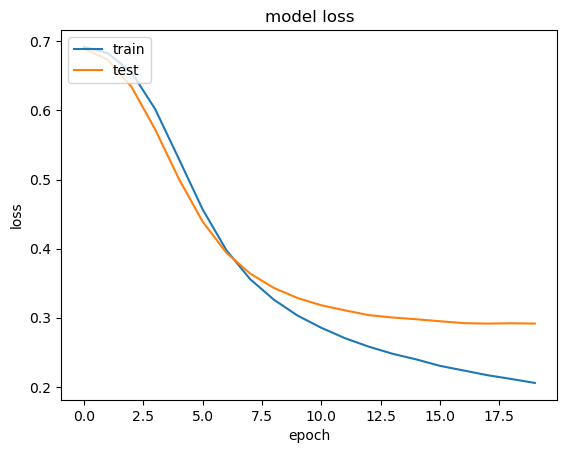

In [130]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


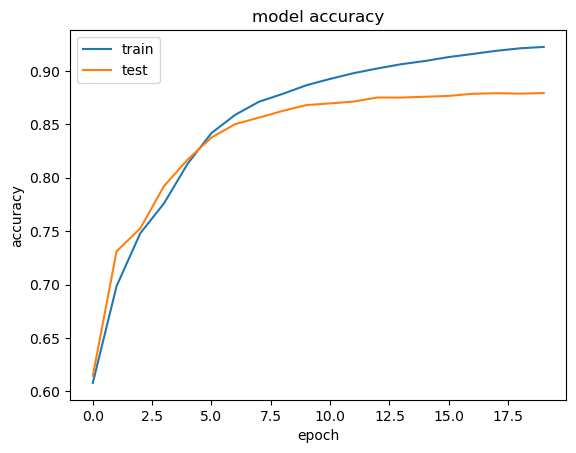

In [131]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [132]:
model = keras.models.load_model(f'{run_dir}/models/best_model_embeddings.h5')

# ---- Evaluate
score  = model.evaluate(x_test_pad, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]

# ---- Confusion matrix

y_sigmoid = model.predict(x_test_pad)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1    

confusion_matrix(y_test, y_pred, labels=range(2))

x_test / loss      : 0.2915
x_test / accuracy  : 0.8791
782/782 [==============================] - 1s 1ms/step


array([[10947,  1553],
       [ 1469, 11031]], dtype=int64)

## Step 5 - Have a look at the embeddings
### 5.1 Retrieve embeddings

In [133]:
embeddings = model.layers[0].get_weights()[0]
print('Shape of embeddings : ',embeddings.shape)

Shape of embeddings :  (5000, 32)


### 5.2 - Build a nice dictionary

In [37]:
word_embedding = { index_word[i]:embeddings[i] for i in range(vocab_size) }

### 5.3 Show embedding of a word :

In [38]:
word_embedding['nice']

array([-0.21398099, -0.2009181 , -0.19416028, -0.22361234, -0.22315247,
       -0.14475106, -0.17572384, -0.2102488 ,  0.18182808, -0.16073155,
        0.1373523 ,  0.21169475,  0.17217973, -0.19426164, -0.17762838,
        0.20462377, -0.11939023,  0.1633577 , -0.18128419,  0.17899631,
        0.13432898, -0.11889859, -0.02190801,  0.20231494, -0.14132808,
       -0.19595253, -0.16102694, -0.16163325, -0.17362717, -0.17559092,
        0.19161919,  0.17176557], dtype=float32)

In [149]:
embeddings = pd.DataFrame(word_embedding)

#### Few usefull functions to play with

In [39]:
# Return a l2 distance between 2 words
#
def l2w(w1,w2):
    v1=word_embedding[w1]
    v2=word_embedding[w2]
    return np.linalg.norm(v2-v1)

# Show distance between 2 words 
#
def show_l2(w1,w2):
    print(f'\nL2 between [{w1}] and [{w2}] : ',l2w(w1,w2))

# Displays the 15 closest words to a given word
#
def neighbors(w1):
    v1=word_embedding[w1]
    dd={}
    for i in range(4, 1000):
        w2=index_word[i]
        dd[w2]=l2w(w1,w2)
    dd= {k: v for k, v in sorted(dd.items(), key=lambda item: item[1])}
    print(f'\nNeighbors of [{w1}] : ', list(dd.keys())[1:15])
    

### 5.4 Examples

In [134]:
show_l2('nice', 'pleasant')
show_l2('nice', 'horrible')

neighbors('horrible')
neighbors('great')



L2 between [nice] and [pleasant] :  0.65517867

L2 between [nice] and [horrible] :  3.6928334

Neighbors of [horrible] :  ['terrible', 'avoid', 'save', 'poor', 'badly', 'worse', 'annoying', 'ridiculous', 'mess', 'unless', 'lame', 'predictable', 'bad', 'boring']

Neighbors of [great] :  ['amazing', 'fantastic', '9', 'wonderful', 'highly', 'superb', 'enjoyed', 'loved', 'brilliant', 'definitely', 'enjoyable', 'perfectly', 'today', 'fun']


## Question

1. Is this method designed to force the embeddings to have semantic meaning?
2. Give a visualization of the word embeddings by doing a PCA on the embedding matrix. Plot some of the words the space of the first two Principal Components. 
3. Give some interpretation on the PCs of these embeddings.

1. Yes, because the Embedding layer is used to determine the context in which the word is placed.

2. Let's do this :

In [193]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
Embeddings = pca.fit_transform(embeddings)

component_names = [f"PC{i+1}" for i in range(Embeddings.shape[1])]
X_pca = pd.DataFrame(Embeddings, columns=component_names)

X_pca

,PC1,PC2
0,-7.688959,0.130287
1,-7.591529,-0.077185
2,-7.939390,0.455867
3,-7.742244,0.241474
4,-7.825352,-0.175526
5,-7.904263,-0.306143
6,-7.786900,-0.094992
7,-7.593771,-0.127542
8,13.877105,-0.734148
9,-7.943485,0.260942


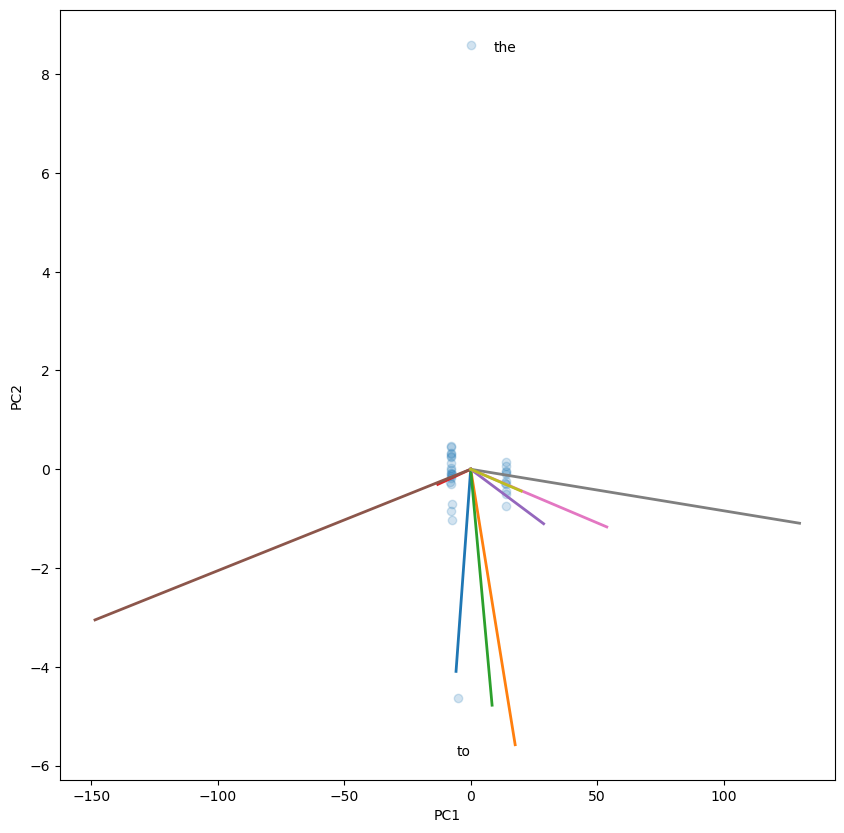

In [192]:
words = ["to","and","the","pink","interests","horrible","nice","great","pleasant"]
word_indice = {x:word_index[x] for x in words}
WORDS = embeddings.iloc[:,list(word_indice.values())]

# Extract the PC1 and PC2 values from X_pca
PC1 = X_pca["PC1"]
PC2 = X_pca["PC2"]

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(PC1, PC2, alpha=0.2)

for word in words:
    word_vec = embeddings.iloc[:, word_index[word]]
    ax.plot([0, np.dot(word_vec, PC1)], [0, np.dot(word_vec, PC2)], linewidth=2)
    label_offset = 0.05 * np.abs(np.dot(word_vec, PC1))
    ax.annotate(word, (np.dot(word_vec, PC1), np.dot(word_vec, PC1)), xytext=(np.dot(word_vec, PC1) + label_offset, np.dot(word_vec, PC1)))
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()


Questions 2 and 3: We can thus observe that the neutral words have an ordinal close to 0, while those which give a positive meaning are rather towards the right and those negative towards the left.



PC1 thus gives an idea if the word gives a negative or positive approach.

I did not find an interpretation for PC2.


# Part 3: Train a GRU

## Step 1 : Parameters

In [194]:
epochs               = 10
batch_size           = 128

## Step 2 : Build the model

In [42]:
def get_model(dense_vector_size=128):
    
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim = vocab_size, output_dim = dense_vector_size))
    model.add(keras.layers.GRU(50))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer = 'rmsprop',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

## Step 3 - Train the model
### 3.1 - Get it

In [43]:
model = get_model(32)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          160000    
                                                                 
 gru (GRU)                   (None, 50)                12600     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 172,651
Trainable params: 172,651
Non-trainable params: 0
_________________________________________________________________


### 3.2 - Add callback

In [44]:
os.makedirs(f'{run_dir}/models',   mode=0o750, exist_ok=True)
save_dir = f'{run_dir}/models/best_model_gru.h5'
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 3.3 - Train it

In [45]:
%%time

history = model.fit(x_train_pad,
                    y_train,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test_pad, y_test),
                    verbose         = fit_verbosity,
                    callbacks       = [savemodel_callback])


Epoch 1/10
196/196 [==============================] - 44s 206ms/step - loss: 0.6862 - accuracy: 0.5363 - val_loss: 0.6506 - val_accuracy: 0.5767
Epoch 2/10
196/196 [==============================] - 37s 191ms/step - loss: 0.5651 - accuracy: 0.7155 - val_loss: 0.4845 - val_accuracy: 0.7870
Epoch 3/10
196/196 [==============================] - 38s 194ms/step - loss: 0.3996 - accuracy: 0.8470 - val_loss: 0.3997 - val_accuracy: 0.8533
Epoch 4/10
196/196 [==============================] - 37s 190ms/step - loss: 0.3503 - accuracy: 0.8743 - val_loss: 0.3421 - val_accuracy: 0.8714
Epoch 5/10
196/196 [==============================] - 36s 186ms/step - loss: 0.3204 - accuracy: 0.8858 - val_loss: 0.3403 - val_accuracy: 0.8733
Epoch 6/10
196/196 [==============================] - 42s 216ms/step - loss: 0.3015 - accuracy: 0.8946 - val_loss: 0.3568 - val_accuracy: 0.8632
Epoch 7/10
196/196 [==============================] - 48s 245ms/step - loss: 0.2796 - accuracy: 0.9041 - val_loss: 0.3363 - val_ac

## Step 4 - Evaluate
### 4.1 - Training history

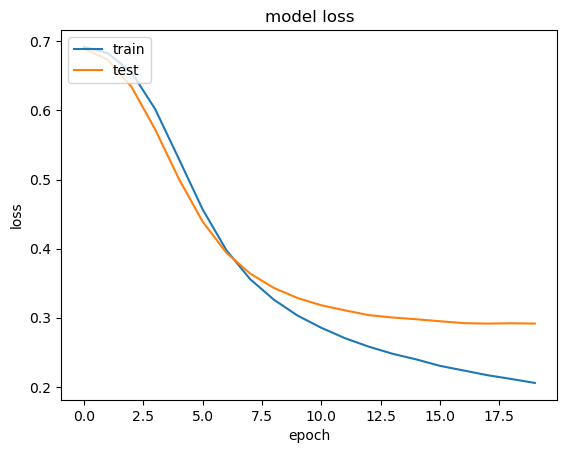

In [135]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

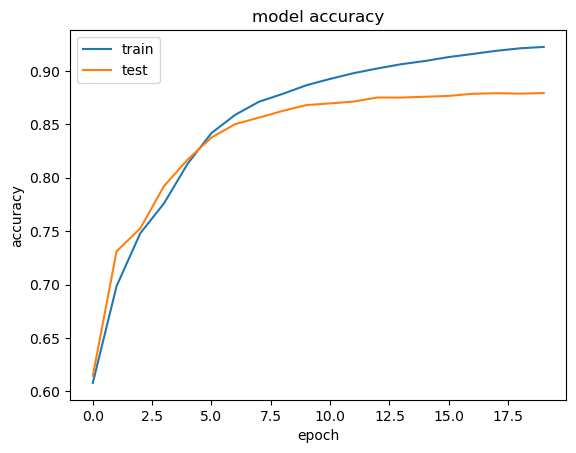

In [136]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 4.2 - Reload and evaluate best model

In [137]:
model = keras.models.load_model(f'{run_dir}/models/best_model_gru.h5')

# ---- Evaluate
score  = model.evaluate(x_test_pad, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]

# ---- Confusion matrix

y_sigmoid = model.predict(x_test_pad)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1    

confusion_matrix(y_test, y_pred, labels=range(2))

x_test / loss      : 0.2919
x_test / accuracy  : 0.8809
782/782 [==============================] - 21s 26ms/step


array([[10818,  1682],
       [ 1296, 11204]], dtype=int64)

## Questions

1. What is the main advantage of this model compared to the previous ones?
2. Compare empirically the performance of the 3 models. Which one would you choose and why?
3. Change the model to use one-hot encoding instead of word embeddings, but keeping a GRU layer. Train it and compare the performance.
4. Play with other recurrent architectures, as described in the [Documentation](https://keras.io/api/layers/recurrent_layers/) and compare their performance. In particular you can compare a bi-directional GRU to a simple GRU, and also use a Long-Short Term Memory Network (LSTM).

1. La couche GRU a l'avantage suivant : Interpreting the hidden state as the memory of a recurrent unit, decide
whether certain units are worth memorizing (in which case the state is
updated), and others are worth forgetting (in which case the state is
reset)


2. On atteint des valeurs de convergence très proches dans les 3 cas, mais le premier modèle convergeait rapidement puis overfittait ; et le deuxième, plus lent mais moins couteux en espace, semblait plus préférable au premier. Le défaut du troisième est qu'il est très couteux en temps, pour offrir au final la même performance. Cependant, il demande moins d'epochs que le deuxième. Son principal avantage est qu'il peut se souvenir des dépendances faites avant. Il a donc une meilleure capacité à apprendre des relations plus complexes. Malgré ce coût en temps, je préfère avoir un modèle capable d'avoir d'apprendre des relations plus complexes : je vais donc choisir le troisième modèle (en espérant qu'on peut tuner les hyperparamtères pour qu'il soit plus rapide.). De plus, il s'agit d'un réseau récurrent qui n'est pas sensible aux problèmes d'exploding/vanishing gradient car il sélectionne ce qu'il doit continuer d'apprendre.

3. Faisons-cela :

In [195]:
%%time

history = model.fit(x_train_one_hot,
                    y_train,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test_one_hot, y_test),
                    verbose         = fit_verbosity,
                    callbacks       = [savemodel_callback])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Epoch 1/10
196/196 [==============================] - ETA: 0s - loss: 0.7017 - accuracy: 0.4963

KeyboardInterrupt: 

The model was too long too run, due to the huge matrix of one hot encoding. I run it during 20 minutes and it was still at the first epoch with an accuracy of the 0.7. So the performance was worse.

4. It is just about replacing the GRU Layer  by a LSTM Layer. Let's try it :

In [197]:
def get_model(dense_vector_size=128):
    
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim = vocab_size, output_dim = dense_vector_size))
    model.add(keras.layers.LSTM(50))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer = 'rmsprop',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

In [198]:
model = get_model(32)

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 32)          160000    
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dense_44 (Dense)            (None, 1)                 51        
                                                                 
Total params: 176,651
Trainable params: 176,651
Non-trainable params: 0
_________________________________________________________________


In [199]:
os.makedirs(f'{run_dir}/models',   mode=0o750, exist_ok=True)
save_dir = f'{run_dir}/models/best_model_gru.h5'
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

In [200]:
%%time

history = model.fit(x_train_pad,
                    y_train,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test_pad, y_test),
                    verbose         = fit_verbosity,
                    callbacks       = [savemodel_callback])


Epoch 1/10
196/196 [==============================] - 61s 299ms/step - loss: 0.6411 - accuracy: 0.6062 - val_loss: 0.4429 - val_accuracy: 0.8344
Epoch 2/10
196/196 [==============================] - 50s 253ms/step - loss: 0.4550 - accuracy: 0.8198 - val_loss: 0.3949 - val_accuracy: 0.8492
Epoch 3/10
196/196 [==============================] - 49s 252ms/step - loss: 0.3795 - accuracy: 0.8624 - val_loss: 0.8504 - val_accuracy: 0.5815
Epoch 4/10
196/196 [==============================] - 52s 264ms/step - loss: 0.3387 - accuracy: 0.8768 - val_loss: 0.4357 - val_accuracy: 0.8571
Epoch 5/10
196/196 [==============================] - 53s 273ms/step - loss: 0.3104 - accuracy: 0.8881 - val_loss: 0.8548 - val_accuracy: 0.7553
Epoch 6/10
196/196 [==============================] - 55s 279ms/step - loss: 0.3115 - accuracy: 0.8832 - val_loss: 0.5211 - val_accuracy: 0.8345
Epoch 7/10
196/196 [==============================] - 51s 259ms/step - loss: 0.3073 - accuracy: 0.8951 - val_loss: 0.3493 - val_ac

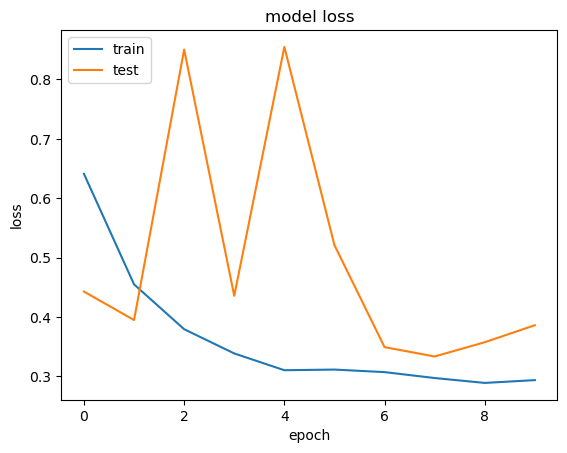

In [201]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

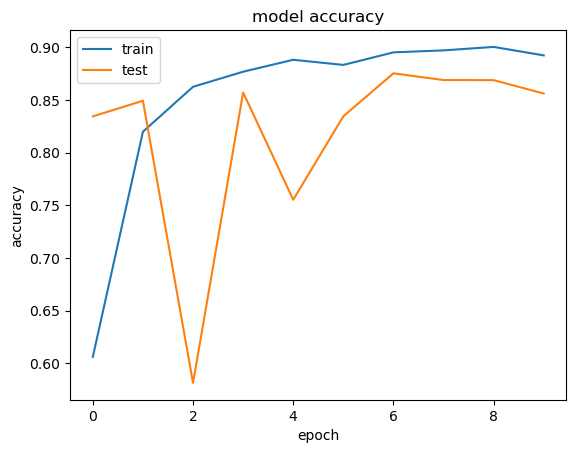

In [202]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Cela n'a pas donné de très bons résultats par rapport au GRU, mais il fallait peut être passer plus de temps sur les hyperparamètres.